已生成500行结果


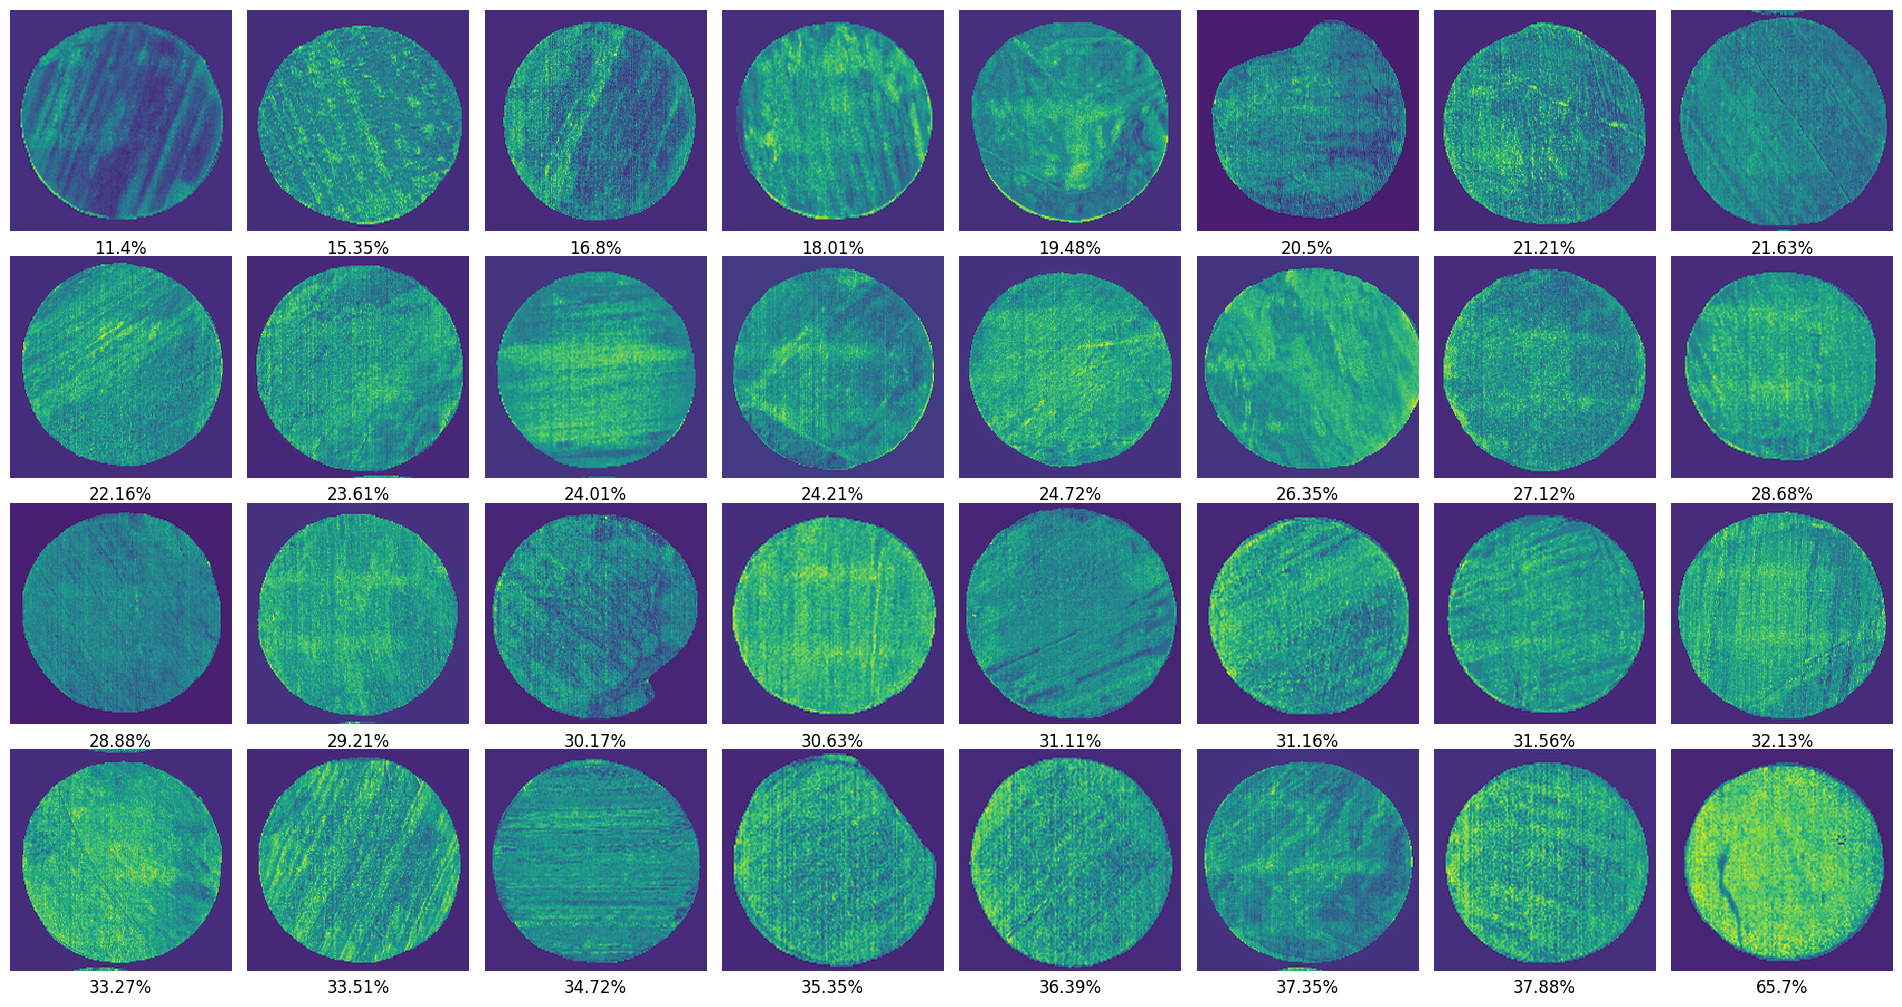

In [3]:
import sys
sys.path.append('./')
sys.path.append('../')
sys.path.append('.../')
from time import sleep
from models.models import ConvPredictor
import spectral
from configs.training_cfg import device
import torch
import ast
import numpy as np
from PIL import Image
from spectral import imshow
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from scipy.ndimage import zoom

spectral.settings.envi_support_nonlowercase_params = True

mask_rgb_values = [[255,242,0],[34,177,76],[255,0,88]]

# 再此处指定模型

# model = feature_conbined_regression(freeze=False).to(device).eval()
model = ConvPredictor().to(device).eval()
model.load_state_dict(torch.load("D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\(0)2x_1diff1\\fold0_step100000.pt"))

corp_pos = [
    {"name": "13", "fullname": "13_A", "position": (133, 48), "size": (142, 129)},
    {"name": "25", "fullname": "25_A", "position": (71, 109), "size": (186, 133)},
    {"name": "56", "fullname": "56_B", "position": (86, 199), "size": (196, 166)},
    {"name": "14", "fullname": "14_B", "position": (115, 186), "size": (149, 130)},
    {"name": "9", "fullname": "9_C", "position": (93, 328), "size": (187, 164)},
    {"name": "27", "fullname": "27_A", "position": (94, 5), "size": (199, 159)},
    {"name": "32", "fullname": "32_A", "position": (82, 15), "size": (188, 163)},
    {"name": "41", "fullname": "41_B", "position": (80, 154), "size": (184, 157)},
    {"name": "53", "fullname": "53_C", "position": (86, 348), "size": (195, 163)},
    {"name": "47", "fullname": "47_A", "position": (92, 23), "size": (188, 160)},
    {"name": "17", "fullname": "17_A", "position": (93, 20), "size": (149, 128)},
    {"name": "47", "fullname": "47_C", "position": (113, 332), "size": (194, 164)},
    {"name": "33", "fullname": "33_C", "position": (82, 310), "size": (194, 168)},
    {"name": "4", "fullname": "4_C", "position": (145, 323), "size": (174, 163)},
    {"name": "7", "fullname": "7_C", "position": (98, 341), "size": (187, 164)},
    {"name": "18", "fullname": "18_C", "position": (86, 321), "size": (152, 135)},
    {"name": "55", "fullname": "55_B", "position": (102, 195), "size": (190, 168)},
    {"name": "27", "fullname": "27_B", "position": (96, 158), "size": (190, 163)},
    {"name": "49", "fullname": "49_A", "position": (102, 16), "size": (182, 159)},
    {"name": "20", "fullname": "20_A", "position": (100, 36), "size": (141, 129)},
    {"name": "5", "fullname": "5_C", "position": (99, 335), "size": (180, 156)},
    {"name": "11", "fullname": "11_B", "position": (123, 158), "size": (150, 130)},
    {"name": "13", "fullname": "13_C", "position": (119, 319), "size": (149, 129)},
    {"name": "45", "fullname": "45_A", "position": (87, 27), "size": (194, 160)},
    {"name": "32", "fullname": "32_B", "position": (85, 170), "size": (195, 164)},
    {"name": "2", "fullname": "2_B", "position": (67, 154), "size": (185, 159)},
    {"name": "26", "fullname": "26_B", "position": (114, 149), "size": (177, 131)},
    {"name": "38", "fullname": "38_B", "position": (104, 171), "size": (143, 125)},
    {"name": "37", "fullname": "37_A", "position": (107, 16), "size": (148, 123)},
    {"name": "51", "fullname": "51_C", "position": (104, 36), "size": (185, 165)},
    {"name": "60", "fullname": "60_B", "position": (119, 144), "size": (147, 127)},
    {"name": "22", "fullname": "22_A", "position": (104, 40), "size": (146, 128)},
]


# 对corps根据name进行分组
corp_group = {}
for corp in corp_pos:
    if corp['name'] not in corp_group:
        corp_group[corp['name']] = []
    corp_group[corp['name']].append(corp)


# 遍历整个corp_group中的每个key
for key in corp_group.keys():
    # 读取图片
    img = spectral.envi.open("D:\\IR_DATA\\spectral_data\\{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr".format(key))
    img_data = torch.Tensor(img.asarray()/6000)[:,:,:]
    gt_TFe = ast.literal_eval(img.metadata['gt_TFe'])
    mask = np.array(Image.open("D:\\IR_DATA\\spectral_data\\{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr_mask.png".format(key)))
    mask_t = torch.ones(mask.shape[0], mask.shape[1])
    
    row,col,_ = img_data.shape

    # 用模型预测当前图片，得到预测结果热图，并将mask中的值不属于mask_rgb_values的值置为0
    for i in range(row):
        for j in range(col):
            if mask[i,j].tolist() not in mask_rgb_values:
                mask_t[i,j] = 0

    with torch.no_grad():
        heat_map = []

        for i in range(row):
            heat_map.append(model(img_data[i].to(device)).squeeze(1).unsqueeze(0).to("cpu"))
            torch.cuda.empty_cache()
            if (i+1)%50 == 0:
                print("\r已生成{}行结果".format(i+1), end="")
    
    heat_map = torch.cat(heat_map, dim=0)
    heat_map = heat_map * mask_t

    for corp in corp_group[key]:
        x,y = corp['position']
        w,h = corp['size']
        # 根据fullname的最后一个字母判断是A还是B还是C（index: 0,1,2）得到对应样本的真值
        gt = gt_TFe[ord(corp['fullname'][-1]) - 65]
        corp['gt'] = float(gt)

        # 根据corp的位置和大小，截取heat_map中对应的部分，并添加到corp中
        corp['heat_map'] = heat_map[y:y+h,x:x+w]

        

    # hm = sns.heatmap(heat_map.numpy(), cmap="viridis", xticklabels=False, yticklabels=False)

# 把这32个热图画出来
# 创建一个新的matplotlib图形
fig, axs = plt.subplots(4, 8, figsize=(20, 10))

# 计算最大的热图大小
max_size = max(max(item["size"]) for item in corp_pos)

# 对于每个字典：
for i, item in enumerate(corp_pos):
    # 使用"position"和"size"键创建一个热图
    heatmap = item["heat_map"]
    # 调整热图的大小与最大的那个热图一样
    zoom_factors = [max_size/dim for dim in item["size"]]
    zoom_factors.reverse()
    heatmap_resized = zoom(heatmap, zoom_factors)
    # 使用`subplot`将热图添加到图形中
    im = axs[i//8, i%8].imshow(heatmap_resized, cmap='viridis', interpolation='nearest')
    axs[i//8, i%8].axis('off')
    # 在每个子图下面添加一个百分比标签
    # axs[i//8, i%8].text(0.5, -0.1, f'{item["gt"]}%', size=12, ha="center", 
    #                      transform=axs[i//8, i%8].transAxes)
    axs[i//8, i%8].text(0.5, -0.1, f'{item["gt"]}%', size=12, ha="center", 
                         transform=axs[i//8, i%8].transAxes)

# 调整子图的间距
plt.subplots_adjust(wspace=0.2, hspace=2)

# 在整个图形旁边添加一个色度条
# fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', fraction=.5)

# 保存图形
plt.tight_layout()
# plt.show()
fig.savefig("heatmap.pdf")

print("")
